# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr


## Load Data

In [2]:
data_full = pd.read_csv("../data/processed/full_all_day_ahead.csv")
print(data_full.shape)
data_full.head()

(2556, 117)


,Date,ACWO_1,ACWO_2,ACWO_3,ACWO_4,ACWO_5,ACWO_6,ADMO_1,ADMO_2,ADMO_3,...,TLRR_5,TLRR_6,ACON,MGEN,OP41,OP42,OP43,OP44,OP45,Abnormal
0,2017-01-01,0.0,NaN,NaN,NaN,NaN,NaN,1929.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-02,0.0,0.0,NaN,NaN,NaN,NaN,2105.0,1929.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-03,0.0,0.0,0.0,NaN,NaN,NaN,1711.0,2105.0,1929.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-04,0.0,0.0,0.0,0.0,NaN,NaN,2060.0,1711.0,2105.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-05,160.0,0.0,0.0,321.0,482.0,NaN,1822.0,2060.0,1711.0,...,20733.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data Dictionary:

| Column Name | Type | Description |
|-------------|------|-------------|
| Date | String | Date under observation (YYYY-MM-DD) |
| Abnormal | Binary | One or more abnormal statuses declared |
| ACON | Binary | M/LCC 2 declared |
| MGEN | Binary | Min Gen Emergency declared |
| OP41 | Binary | OP4 Action 1 declared |
| OP42 | Binary | OP4 Action 2 declared |
| OP43 | Binary | OP4 Action 3 declared |
| OP44 | Binary | OP4 Action 4 declared |
| OP45 | Binary | OP4 Action 5 declared |
| ACWO_* | Numeric | Anticipated cold weather outages |
| ADMO_* | Numeric | Anticipated de-list megawatts offered |
| ADRR_* | Numeric | Available demand response resources |
| CSO_* | Numeric | Total capacity supply obligation |
| DPB_* | Numeric | Dew point in Boston |
| DPH_* | Numeric | Dew point in Hartford | 
| HTB_* | Numeric | High temperature in Boston |
| HTH_* | Numeric | High temperature in Hartford |
| ITP_* | Numeric | Import at time of peak |
| OGO_* | Numeric | Other generation outages |
| PPL_* | Numeric | Projected peak load |
| PS_* | Numeric | Projected surplus or deficiency |
| RRIR_* | Numeric | Required reserve including replacement |
| RRR_* | Numeric | Replacement reserve requirement | 
| RR_* | Numeric | Required reserve | 
| TAGI_* | Numeric | Total available generation and imports |
| TGA_* | Numeric | Total generation available | 
| TLRR_* | Numeric | Total load plus required reserve |

*\* Columns suffixed with "_\*" are n-day ahead attributes. For each, there are values for six days ahead.*  
&nbsp;&nbsp;*E.g., Required reserve: RR_1, RR_2, RR_3, etc.*

In [3]:
cols_1da = [c for c in data_full.columns if c.endswith("_1") or c == "Abnormal"]
data_1da = data_full[cols_1da]
print(data_1da.shape)
data_1da.head()

(2556, 19)


,ACWO_1,ADMO_1,ADRR_1,CSO_1,DPB_1,DPH_1,HTB_1,HTH_1,ITP_1,OGO_1,PPL_1,PS_1,RRIR_1,RRR_1,RR_1,TAGI_1,TGA_1,TLRR_1,Abnormal
0,0.0,1929.0,145.0,30281.0,26.0,24.0,43.0,40.0,3388.0,2399.0,16250.0,14466.0,2483.0,180.0,2303.0,33199.0,29811.0,18733.0,0.0
1,0.0,2105.0,145.0,30281.0,25.0,24.0,40.0,39.0,3388.0,2225.0,17750.0,13316.0,2483.0,180.0,2303.0,33549.0,30161.0,20233.0,0.0
2,0.0,1711.0,145.0,30281.0,43.0,39.0,46.0,41.0,3588.0,2205.0,17690.0,13202.0,2483.0,180.0,2303.0,33375.0,29787.0,20173.0,0.0
3,0.0,2060.0,145.0,30281.0,40.0,37.0,49.0,45.0,3588.0,1863.0,16980.0,14603.0,2483.0,180.0,2303.0,34066.0,30478.0,19463.0,0.0
4,160.0,1822.0,145.0,30281.0,10.0,8.0,35.0,33.0,3588.0,1927.0,18060.0,13061.0,2483.0,180.0,2303.0,33604.0,30016.0,20543.0,0.0


In [4]:
data_1da[data_1da.isna().any(axis=1)]

,ACWO_1,ADMO_1,ADRR_1,CSO_1,DPB_1,DPH_1,HTB_1,HTH_1,ITP_1,OGO_1,PPL_1,PS_1,RRIR_1,RRR_1,RR_1,TAGI_1,TGA_1,TLRR_1,Abnormal
2450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [5]:
data_full.iloc[2450]["Date"]

'2023-09-17'

In [6]:
data_1da = data_1da.dropna()

## Find Redundant Columns

### PS

In [7]:
ps_data = data_1da[["PS_1", "TAGI_1", "PPL_1", "RRIR_1"]]\
  .assign(tagi_ppl_rrir = lambda x: x.TAGI_1 - x.PPL_1 - x.RRIR_1)\
  .assign(diff = lambda x: x.PS_1 - x.tagi_ppl_rrir)
ps_data.head()

,PS_1,TAGI_1,PPL_1,RRIR_1,tagi_ppl_rrir,diff
0,14466.0,33199.0,16250.0,2483.0,14466.0,0.0
1,13316.0,33549.0,17750.0,2483.0,13316.0,0.0
2,13202.0,33375.0,17690.0,2483.0,13202.0,0.0
3,14603.0,34066.0,16980.0,2483.0,14603.0,0.0
4,13061.0,33604.0,18060.0,2483.0,13061.0,0.0


In [8]:
ps_data["diff"].unique()

array([0.])

**Findings:** PS = TAGI-PPL-RRIR

### RRIR

In [9]:
rrir_data = data_1da[["RRR_1", "RR_1", "RRIR_1"]]\
  .assign(rrr_rr = lambda x: x.RRR_1 + x.RR_1)\
  .assign(diff = lambda x: x.RRIR_1 - x.rrr_rr)
rrir_data.head()

,RRR_1,RR_1,RRIR_1,rrr_rr,diff
0,180.0,2303.0,2483.0,2483.0,0.0
1,180.0,2303.0,2483.0,2483.0,0.0
2,180.0,2303.0,2483.0,2483.0,0.0
3,180.0,2303.0,2483.0,2483.0,0.0
4,180.0,2303.0,2483.0,2483.0,0.0


In [10]:
rrir_data["diff"].unique()

array([0.])

**Finding**: RRIR = RRR+RR

### TLRR

In [11]:
tlrr_data = data_1da[["RRR_1", "RR_1", "PPL_1", "TLRR_1"]]\
  .assign(rrr_rr_ppl = lambda x: x.RRR_1 + x.RR_1 + x.PPL_1)\
  .assign(diff = lambda x: x.TLRR_1 - x.rrr_rr_ppl)
tlrr_data.head()

,RRR_1,RR_1,PPL_1,TLRR_1,rrr_rr_ppl,diff
0,180.0,2303.0,16250.0,18733.0,18733.0,0.0
1,180.0,2303.0,17750.0,20233.0,20233.0,0.0
2,180.0,2303.0,17690.0,20173.0,20173.0,0.0
3,180.0,2303.0,16980.0,19463.0,19463.0,0.0
4,180.0,2303.0,18060.0,20543.0,20543.0,0.0


In [12]:
tlrr_data["diff"].unique()

array([0.])

**Finding**: TLRR = RRR+RR+PPL

### TAGI

In [13]:
tagi_data = data_1da[["TGA_1", "ITP_1", "TAGI_1"]]\
  .assign(tga_itp = lambda x: x.ITP_1 + x.TGA_1)\
  .assign(diff = lambda x: x.TAGI_1 - x.tga_itp)
tagi_data.head()

,TGA_1,ITP_1,TAGI_1,tga_itp,diff
0,29811.0,3388.0,33199.0,33199.0,0.0
1,30161.0,3388.0,33549.0,33549.0,0.0
2,29787.0,3588.0,33375.0,33375.0,0.0
3,30478.0,3588.0,34066.0,34066.0,0.0
4,30016.0,3588.0,33604.0,33604.0,0.0


In [14]:
tagi_data["diff"].unique()

array([0.])

**Finding**: TAGI = TGA+ITP

### All Findings

* TAGI = TGA+ITP
* RRIR = RRR+RR
* PS = TAGI-PPL-RRIR = TGA+ITP-PPL-RRR-RR
* TLRR = RRIR+PPL = RRR+RR+PPL

## Data Summary

In [15]:
data_1da.describe()

,ACWO_1,ADMO_1,ADRR_1,CSO_1,DPB_1,DPH_1,HTB_1,HTH_1,ITP_1,OGO_1,PPL_1,PS_1,RRIR_1,RRR_1,RR_1,TAGI_1,TGA_1,TLRR_1,Abnormal
count,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.0,2555.000000,2555.000000,2555.000000,2555.000000
mean,87.317025,1551.774951,333.169472,29773.672016,42.954599,41.488454,59.217221,60.987476,3053.151076,4343.996086,15997.675147,11479.643053,2469.966732,166.966732,2303.0,29947.284932,26894.133855,18467.641879,0.013699
std,402.316988,629.205636,104.812077,1095.186472,17.641260,18.485792,17.153100,18.756608,421.240507,2723.465250,2442.056737,2877.171356,9.530731,9.530731,0.0,3016.025569,2907.177867,2443.259225,0.116259
min,0.000000,1.000000,145.000000,27794.000000,-10.000000,-15.000000,8.000000,6.000000,938.000000,554.000000,11460.000000,2996.000000,2463.000000,160.000000,2303.0,19945.000000,16520.000000,13923.000000,0.000000
25%,0.000000,1074.000000,244.000000,28841.000000,30.000000,28.000000,45.000000,44.000000,2888.000000,2153.000000,14200.000000,9549.000000,2463.000000,160.000000,2303.0,28153.500000,25196.000000,16673.000000,0.000000
50%,0.000000,1476.000000,328.000000,29923.000000,44.000000,43.000000,59.000000,61.000000,3095.000000,3396.000000,15670.000000,11725.000000,2463.000000,160.000000,2303.0,30715.000000,27602.000000,18133.000000,0.000000
75%,0.000000,1918.000000,422.000000,30501.000000,57.000000,57.000000,74.000000,77.000000,3295.000000,6284.000000,17200.000000,13694.500000,2483.000000,180.000000,2303.0,32213.000000,29043.000000,19683.000000,0.000000
max,4864.000000,3813.000000,784.000000,31711.000000,74.000000,75.000000,97.000000,100.000000,4025.000000,12719.000000,26000.000000,18398.000000,2483.000000,180.000000,2303.0,35629.000000,32334.000000,28463.000000,1.000000


In [16]:
data_1da_reduced = data_1da.drop(columns="RR_1")  # RR_1 always has value 2303, thus RRIR = RRR+2303

## Pairplot

In [17]:
# sns.pairplot(data_1da_reduced, hue="Abnormal")

## Correlation

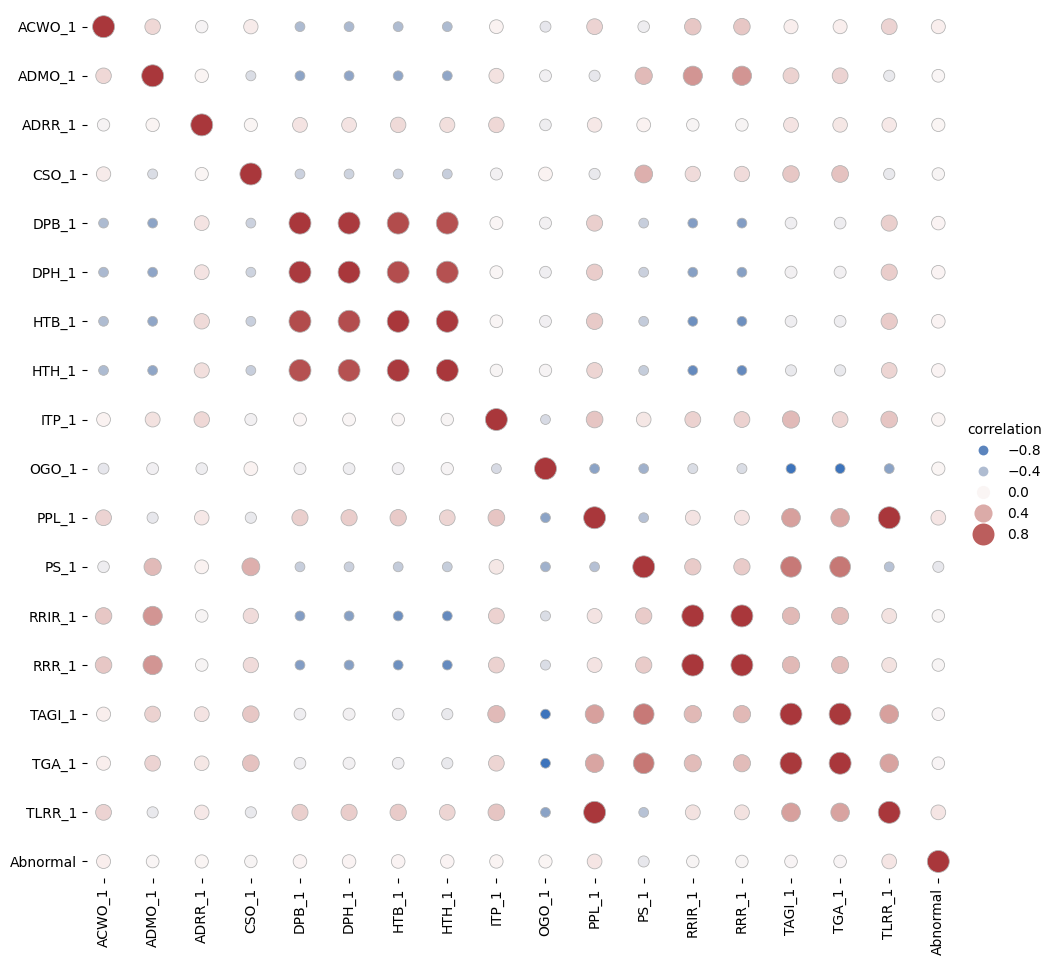

In [18]:
# Compute a correlation matrix and convert to long-form
corr_mat = data_1da_reduced.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

In [19]:
corr_mat2 = data_1da_reduced.corr()
corr_mat2 = corr_mat2.where(np.triu(np.ones(corr_mat2.shape), k=1).astype(bool))
corr_list = corr_mat2.unstack().dropna()
corr_list = abs(corr_list).sort_values(ascending=False)
print(corr_list[corr_list > 0.6])


RRR_1   RRIR_1    1.000000
TLRR_1  PPL_1     0.999993
TGA_1   TAGI_1    0.990557
DPH_1   DPB_1     0.978908
HTH_1   HTB_1     0.978224
TGA_1   OGO_1     0.918151
TAGI_1  OGO_1     0.914378
HTB_1   DPB_1     0.892576
        DPH_1     0.884908
HTH_1   DPB_1     0.873904
        DPH_1     0.868141
RRIR_1  HTH_1     0.752835
RRR_1   HTH_1     0.752835
RRIR_1  HTB_1     0.712488
RRR_1   HTB_1     0.712488
TGA_1   PS_1      0.666194
TAGI_1  PS_1      0.657151
RRR_1   DPB_1     0.609602
RRIR_1  DPB_1     0.609602
dtype: float64


## Occurrences of Abnormal Conditions

In [20]:
df = data_full.drop(index=[2450])
df.value_counts(["Abnormal", "ACON", "MGEN", "OP41", "OP42", "OP43", "OP44", "OP45"])\
  .reset_index(name="count")

,Abnormal,ACON,MGEN,OP41,OP42,OP43,OP44,OP45,count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2520
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,31
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1
4,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1
5,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1


Abnormal
0.0    2520
1.0      35
Name: count, dtype: int64


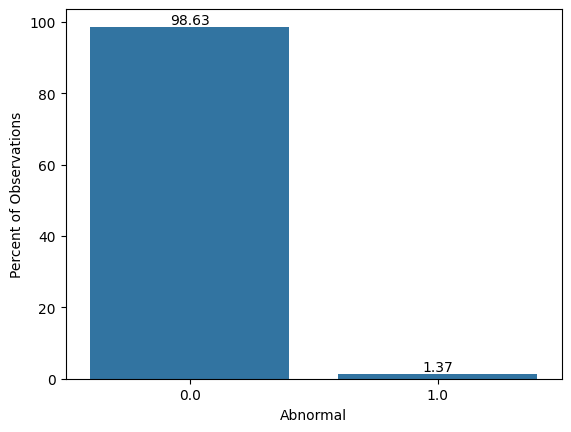

In [21]:
ax = sns.countplot(data_1da_reduced, x="Abnormal", stat="percent")
ax.bar_label(ax.containers[0], fmt="%.02f")
ax.set_ylabel("Percent of Observations")
print(data_1da["Abnormal"].value_counts())

In [22]:
X_cols = data_1da_reduced.drop(columns="Abnormal").columns
X_cols

Index(['ACWO_1', 'ADMO_1', 'ADRR_1', 'CSO_1', 'DPB_1', 'DPH_1', 'HTB_1',
       'HTH_1', 'ITP_1', 'OGO_1', 'PPL_1', 'PS_1', 'RRIR_1', 'RRR_1', 'TAGI_1',
       'TGA_1', 'TLRR_1'],
      dtype='object')

In [23]:
f_stat, p_val = f_classif(data_1da_reduced.drop(columns="Abnormal"), data_1da_reduced.Abnormal)
X_anova = pd.DataFrame({"f_stat": f_stat, "p_val": p_val}, index=X_cols)

f_stat    10.443769
p_val      0.001246
Name: ACWO_1, dtype: float64


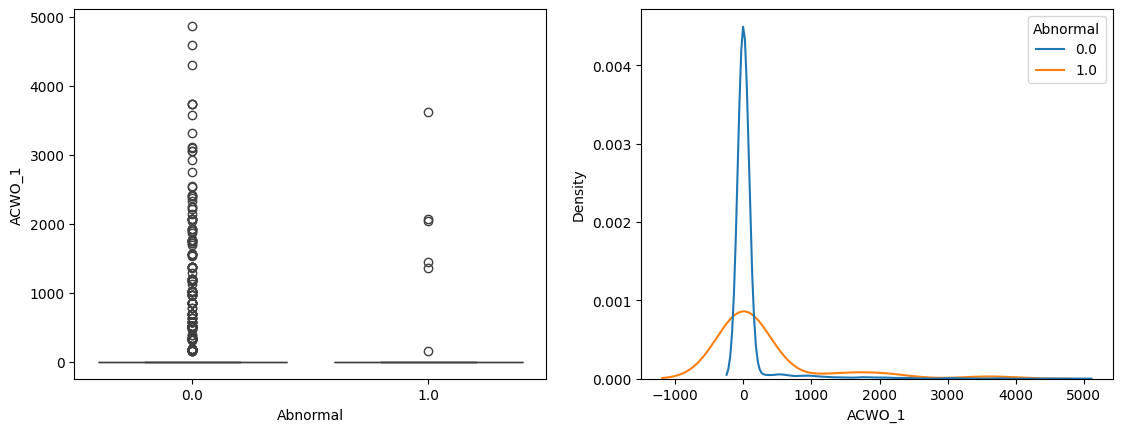

f_stat    1.993890
p_val     0.158057
Name: ADMO_1, dtype: float64


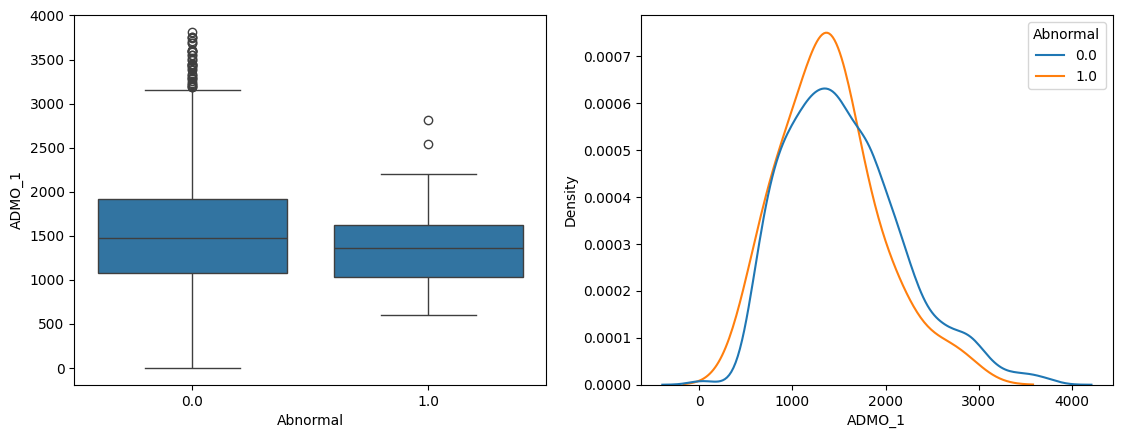

f_stat    0.023325
p_val     0.878627
Name: ADRR_1, dtype: float64


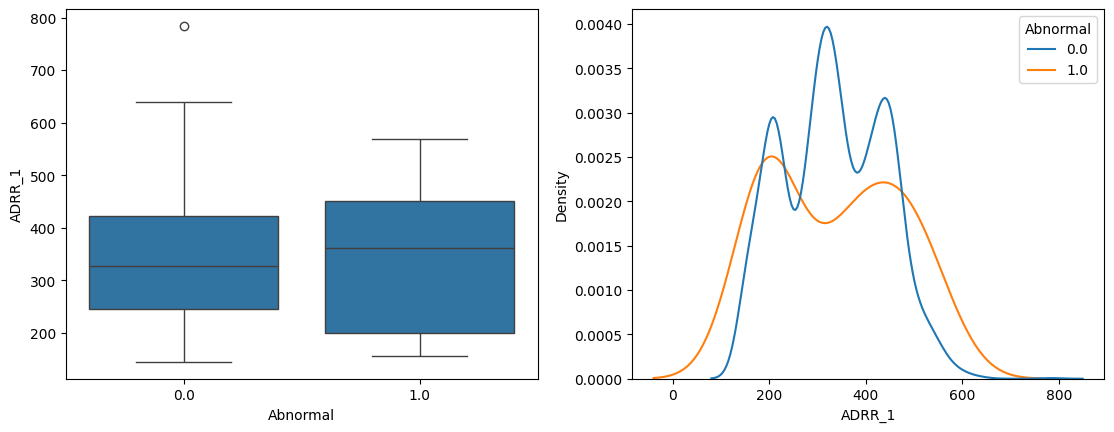

f_stat    5.101843
p_val     0.023984
Name: CSO_1, dtype: float64


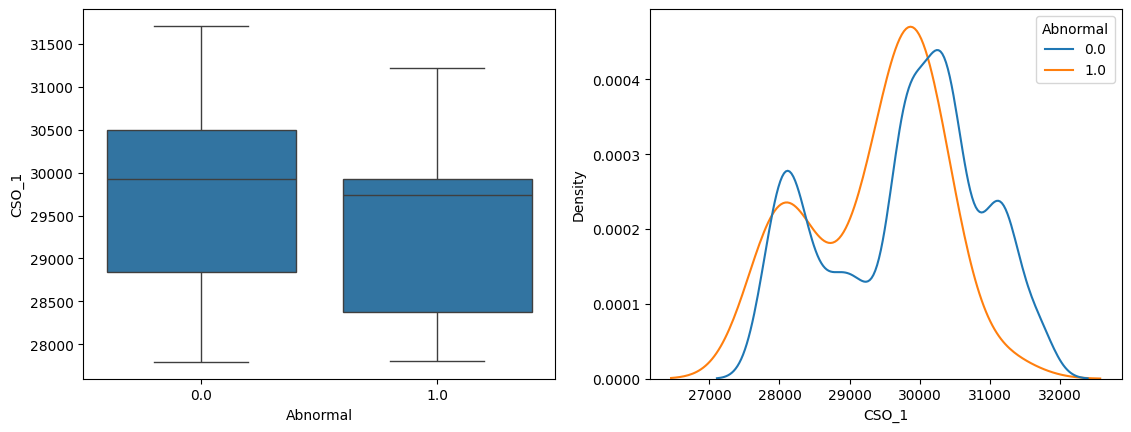

f_stat    2.000950
p_val     0.157323
Name: DPB_1, dtype: float64


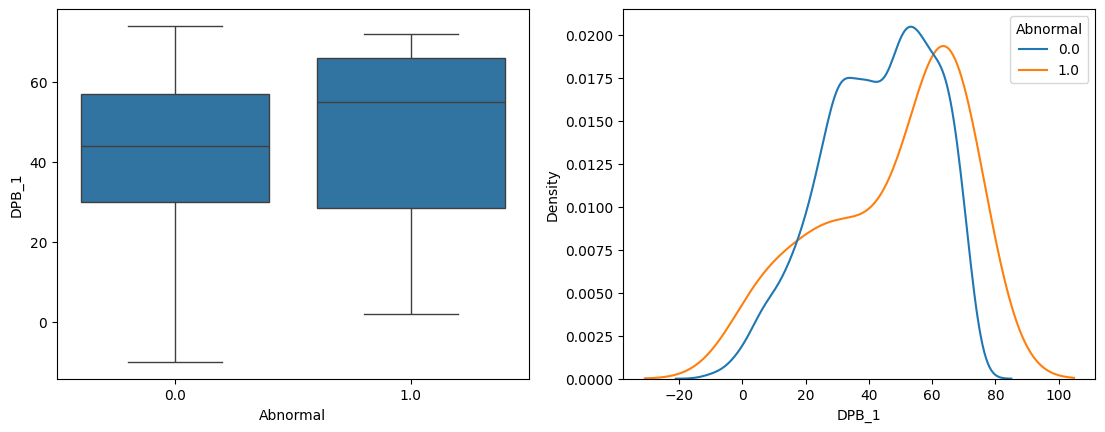

f_stat    1.780493
p_val     0.182208
Name: DPH_1, dtype: float64


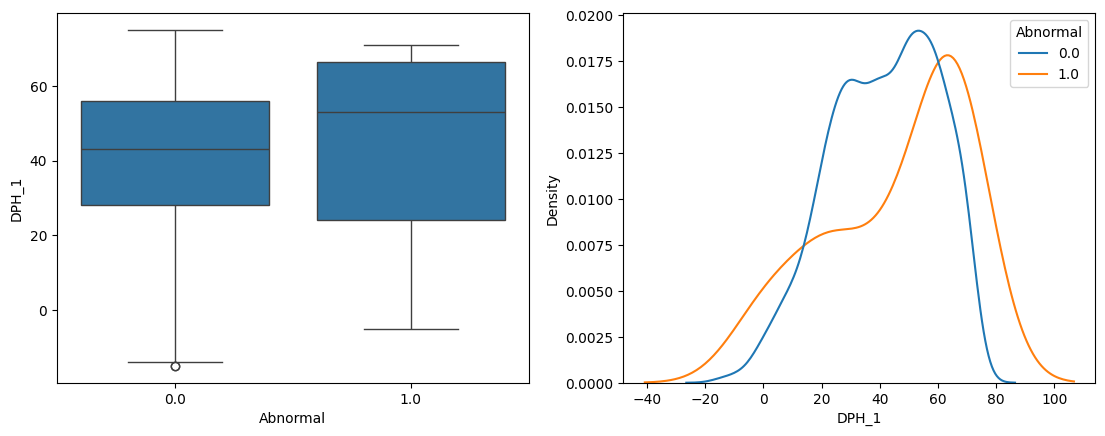

f_stat    2.440486
p_val     0.118364
Name: HTB_1, dtype: float64


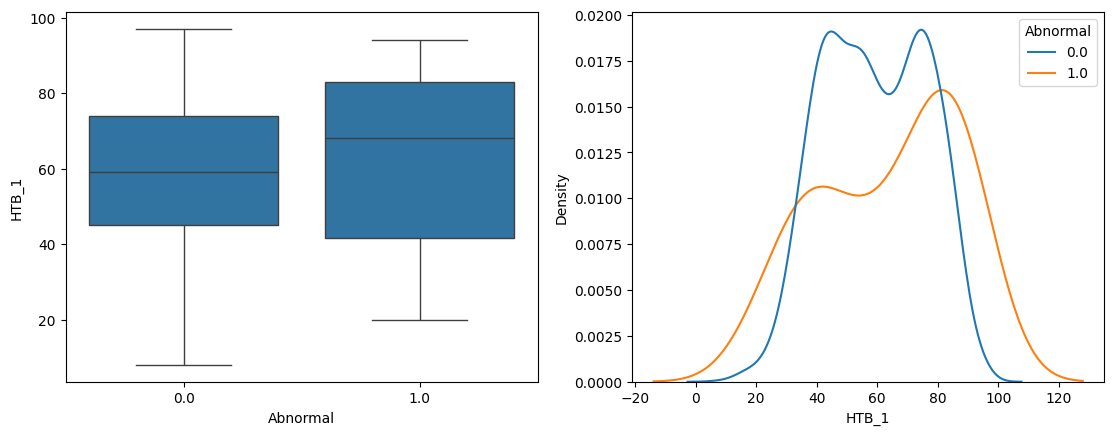

f_stat    1.889020
p_val     0.169433
Name: HTH_1, dtype: float64


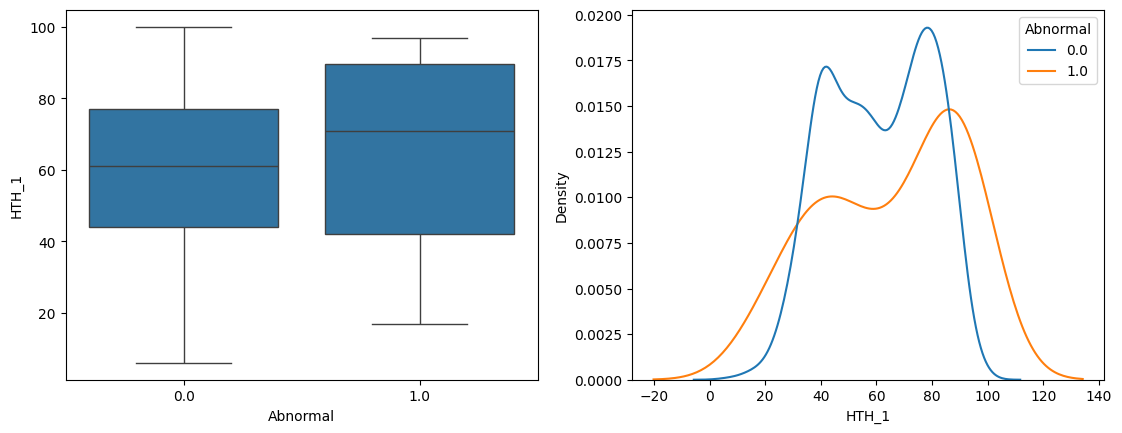

f_stat    0.751559
p_val     0.386065
Name: ITP_1, dtype: float64


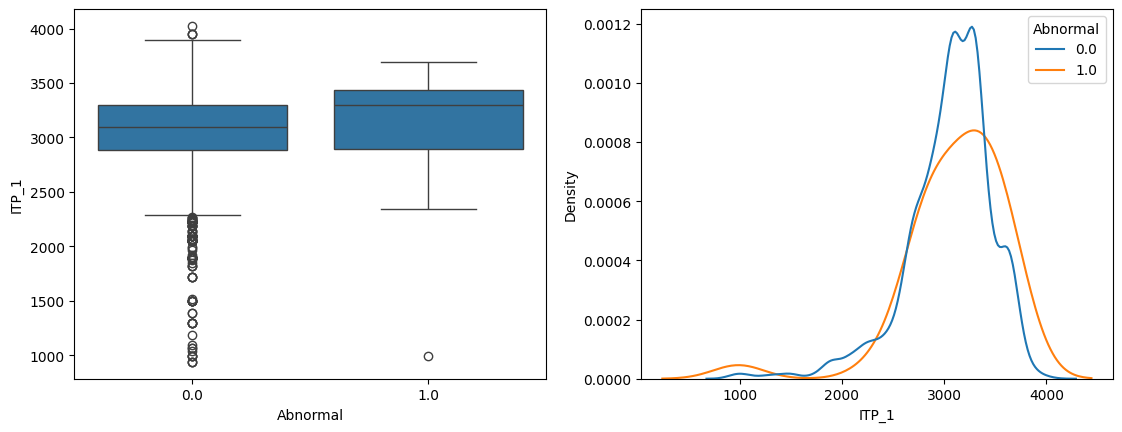

f_stat    0.055404
p_val     0.813932
Name: OGO_1, dtype: float64


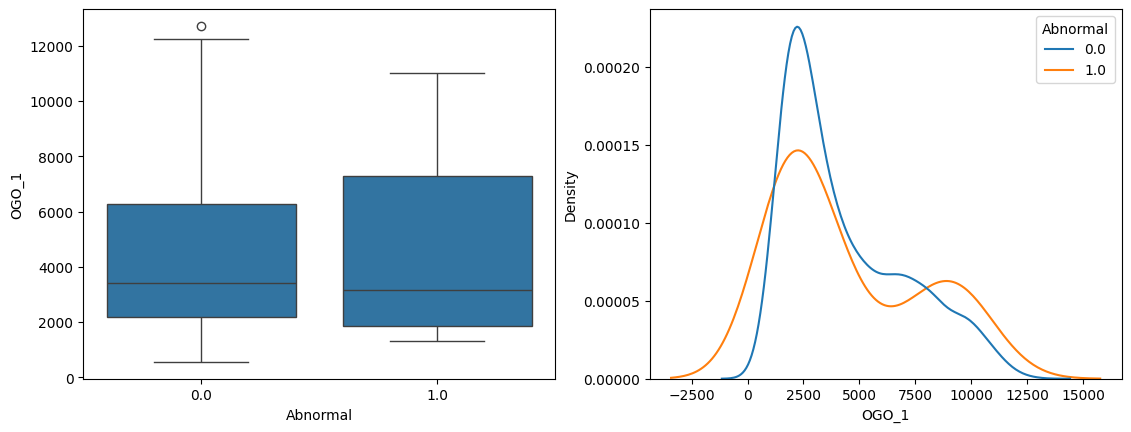

f_stat    3.384565e+01
p_val     6.711452e-09
Name: PPL_1, dtype: float64


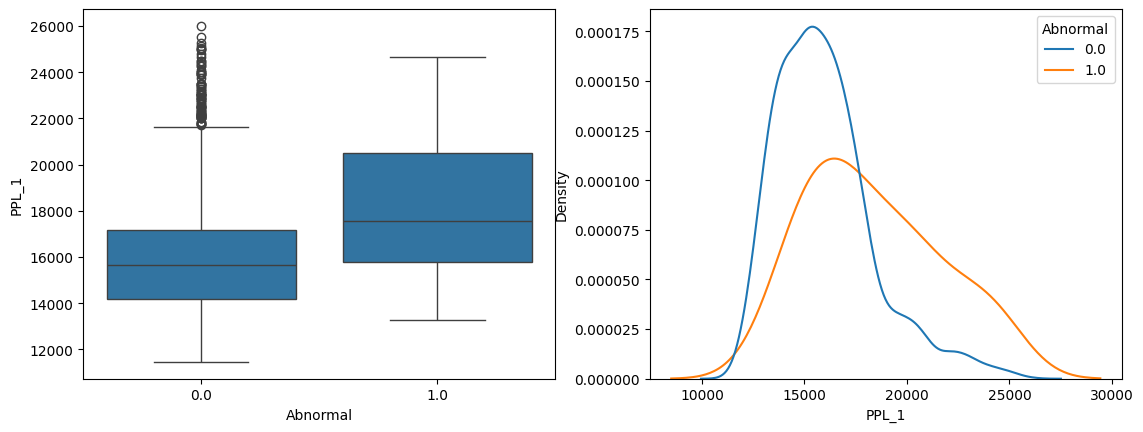

f_stat    4.448873e+01
p_val     3.125121e-11
Name: PS_1, dtype: float64


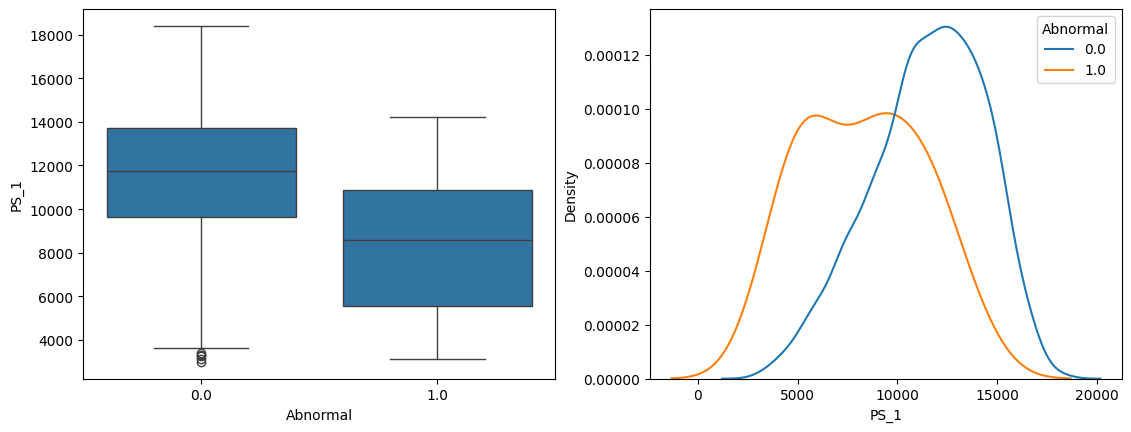

f_stat    4.898052
p_val     0.026975
Name: RRIR_1, dtype: float64


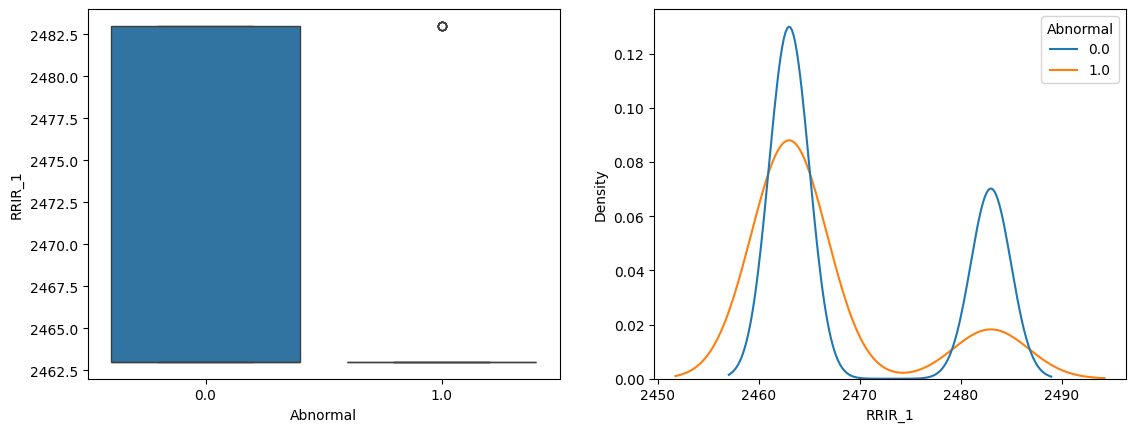

f_stat    4.898052
p_val     0.026975
Name: RRR_1, dtype: float64


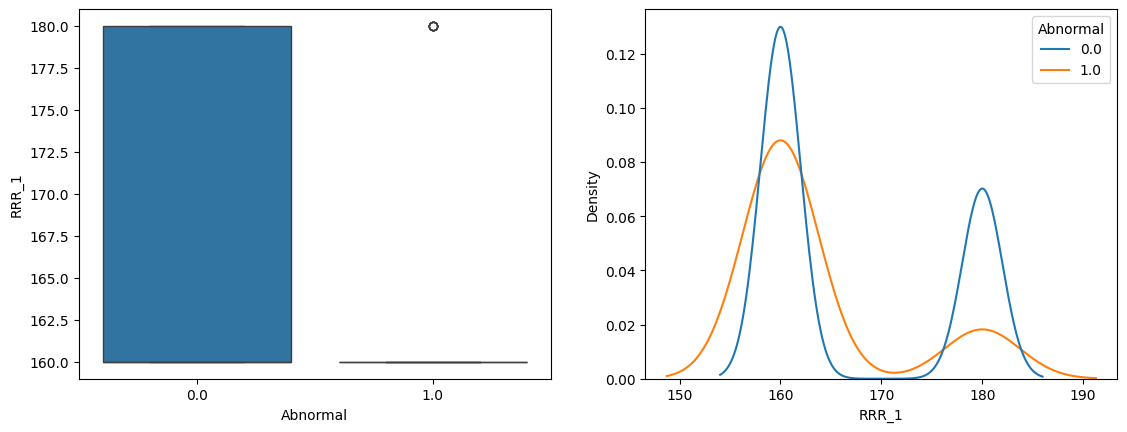

f_stat    2.677769
p_val     0.101881
Name: TAGI_1, dtype: float64


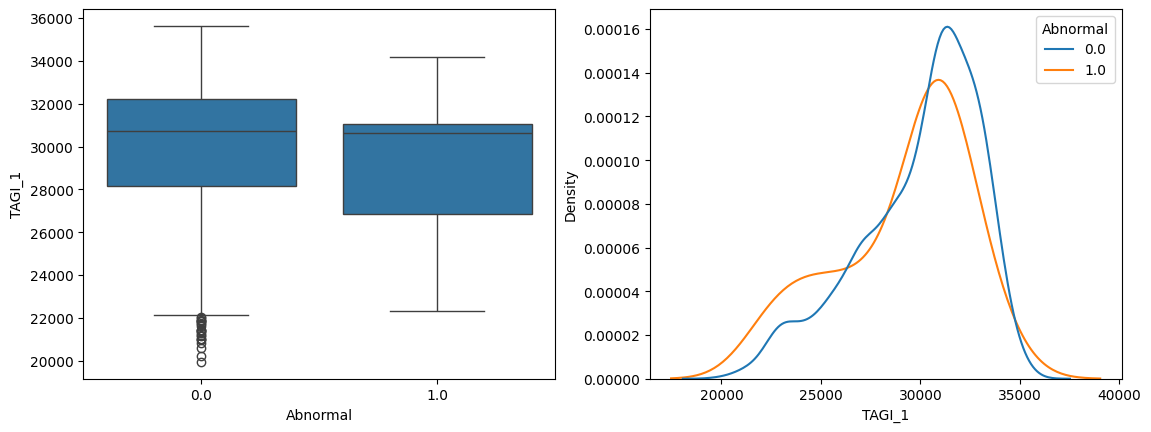

f_stat    3.325335
p_val     0.068337
Name: TGA_1, dtype: float64


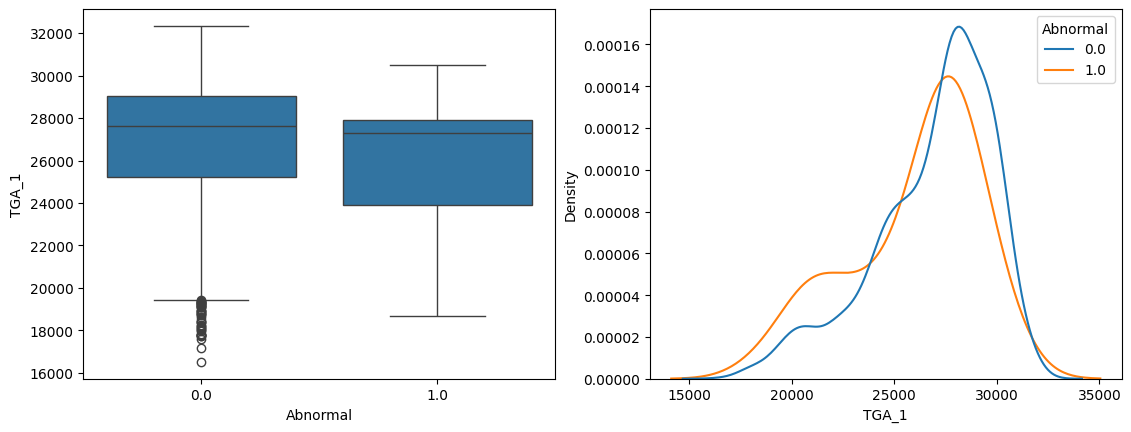

f_stat    3.370968e+01
p_val     7.190746e-09
Name: TLRR_1, dtype: float64


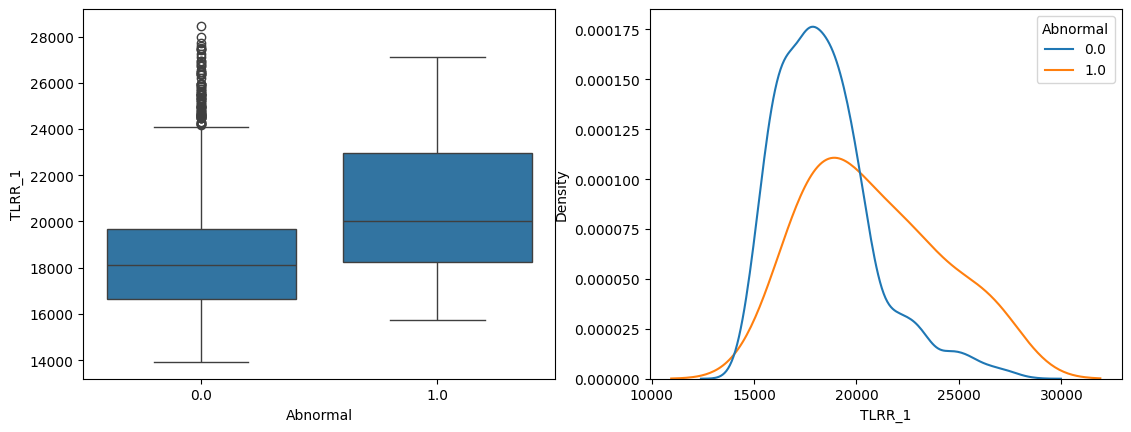

In [24]:
for col in X_cols:
  print(X_anova.loc[col])
  fig, axes = plt.subplots(ncols=2)
  sns.boxplot(data_1da_reduced, y=col, x="Abnormal", ax=axes[0])
  sns.kdeplot(data_1da_reduced, x=col, hue="Abnormal", common_norm=False, ax=axes[1])
  fig.set_figwidth(fig.get_figwidth()+7)
  plt.show()

In [25]:
X_anova.round(4).sort_values("f_stat", ascending=False)

,f_stat,p_val
PS_1,44.4887,0.0000
PPL_1,33.8456,0.0000
TLRR_1,33.7097,0.0000
ACWO_1,10.4438,0.0012
CSO_1,5.1018,0.0240
RRIR_1,4.8981,0.0270
RRR_1,4.8981,0.0270
TGA_1,3.3253,0.0683
TAGI_1,2.6778,0.1019
HTB_1,2.4405,0.1184


## Feature Clustering

In [26]:
def make_dendro(X):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
  corr = spearmanr(X).correlation

  # Ensure the correlation matrix is symmetric
  corr = (corr + corr.T) / 2
  np.fill_diagonal(corr, 1)

  # We convert the correlation matrix to a distance matrix before performing
  # hierarchical clustering using Ward's linkage.
  distance_matrix = 1 - np.abs(corr)
  dist_linkage = hierarchy.ward(squareform(distance_matrix))
  dendro = hierarchy.dendrogram(
      dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
  )
  dendro_idx = np.arange(0, len(dendro["ivl"]))

  im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap="bwr")
  ax2.set_xticks(dendro_idx)
  ax2.set_yticks(dendro_idx)
  ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
  ax2.set_yticklabels(dendro["ivl"])
  fig.colorbar(im)
  _ = fig.tight_layout()

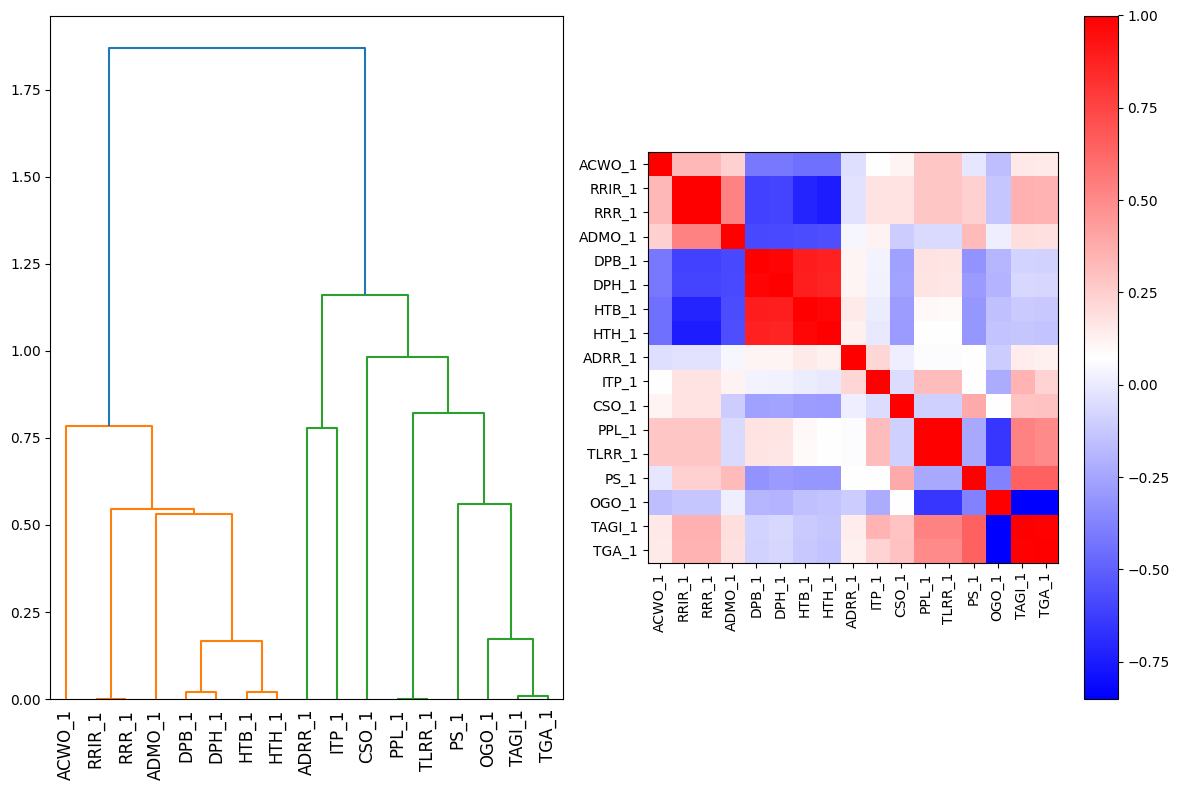

In [27]:
X = data_1da_reduced[X_cols]
make_dendro(X)


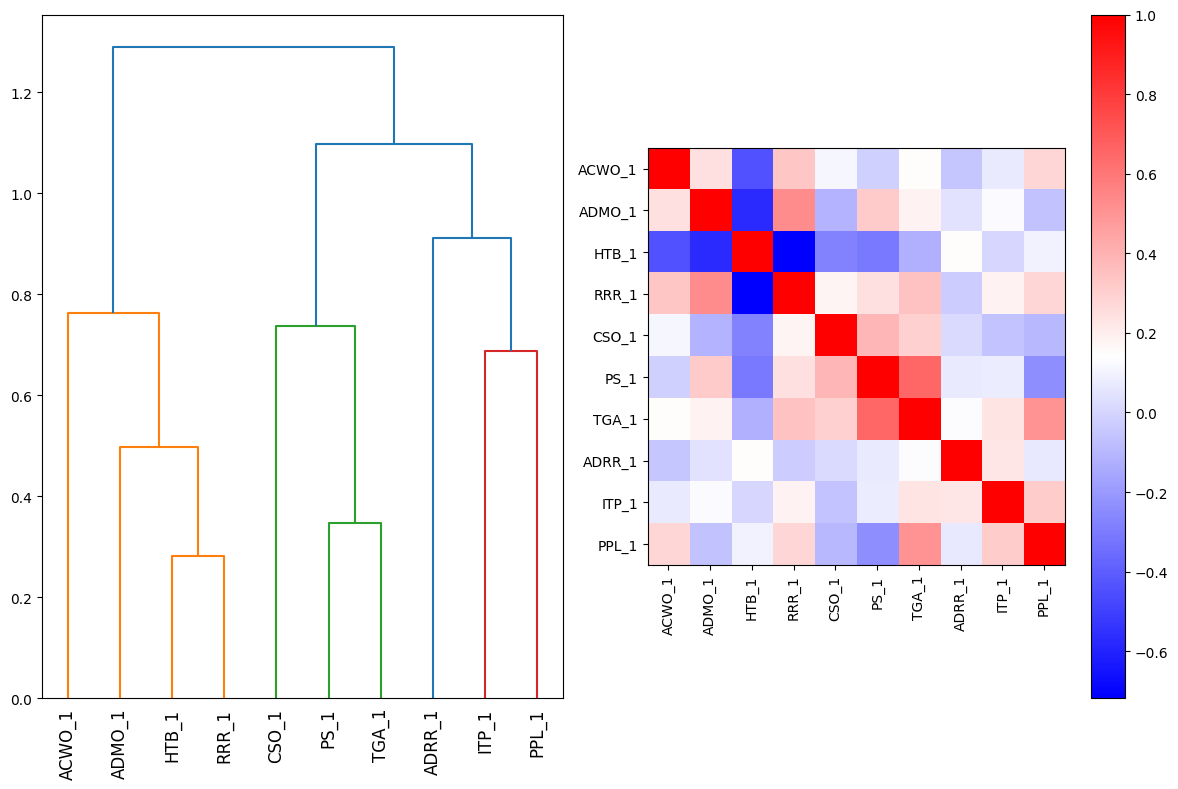

In [28]:
X_reduced = X.drop(columns=["DPB_1", "DPH_1", "HTH_1", "TAGI_1", "RRIR_1", "TLRR_1", "OGO_1"])
make_dendro(X_reduced)

## PCA

In [29]:
pca = PCA()
pca.fit(StandardScaler().fit_transform(X_reduced))
pca.explained_variance_ratio_.cumsum()

array([0.28093458, 0.45196581, 0.61022919, 0.72944602, 0.81996763,
       0.89577824, 0.95710537, 0.98478138, 1.        , 1.        ])